<a id='1'></a>
# 数据探索

In [88]:
#encoding: utf-8

import pandas as pd
data = pd.read_csv('data/data.csv', encoding='GB18030')
print(data.shape)

(4754, 90)


## 去重

去掉重复数据，即那些属性都一样的数据。

In [89]:
data.drop_duplicates(inplace=True)
print(data.shape)

(4754, 90)


<a id='1.1'></a>
## 删除和预测无关的数据

**删除原则**

* 特征只有单一的值，即该特征所有样本值都一样
* 特征属性值个数和行数相同
* 特征和预测无关

In [90]:
# 查看每列的类型
types = data.dtypes
print(len(types))
print types[0:45]
print('-----------------------------------------------------------')
print types[45:]

90
Unnamed: 0                                      int64
custid                                          int64
trade_no                                       object
bank_card_no                                   object
low_volume_percent                            float64
middle_volume_percent                         float64
take_amount_in_later_12_month_highest           int64
trans_amount_increase_rate_lately             float64
trans_activity_month                          float64
trans_activity_day                            float64
transd_mcc                                    float64
trans_days_interval_filter                    float64
trans_days_interval                           float64
regional_mobility                             float64
student_feature                               float64
repayment_capability                            int64
is_high_user                                    int64
number_of_trans_from_2011                     float64
first_transaction_time   

In [91]:
# 1表示某列无缺失值情况下，所有值都一样；
# 2表示有缺失值情况下，所有值都一样
# count表示无缺失值情况下，所有值都不一样
# 表示有缺失值情况下，所有值都不一样
# 但对于离散值，其实所有值都一样也没关系
for i in data.columns:
    count = data[i].count()
    if len(list(data[i].unique())) in [1, count, count - 1]:
        print(i)

Unnamed: 0
custid
trade_no
bank_card_no
source


In [92]:
# 'source'和'bank_card_no'值无区分度
# ‘custid’、‘trade_no’、‘id_name’和预测无关
data.drop(['custid', 'trade_no', 'bank_card_no', 'id_name', 'source'], axis = 1, inplace=True)

In [93]:
# 'Unnamed: 0'和预测无关
data.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [94]:
first_transaction_time = data['first_transaction_time']
latest_query_time = data['latest_query_time']
loans_latest_time = data['loans_latest_time']
# 先删除data
data.drop(['first_transaction_time', 'latest_query_time', 'loans_latest_time'], axis = 1, inplace=True)

In [103]:
# 探索处理日期类型的方法
print len(first_transaction_time.unique())
print len(latest_query_time.unique())
print len(loans_latest_time.unique())

# print first_transaction_time[1]

latest_query_time_month = pd.to_datetime(latest_query_time).dt.month # 月
latest_query_time_weekday = pd.to_datetime(latest_query_time).dt.weekday # 星期
latest_query_time_day = pd.to_datetime(latest_query_time).dt.day # 天
 
loans_latest_time_month = pd.to_datetime(loans_latest_time).dt.month # 月
loans_latest_time_weekday = pd.to_datetime(loans_latest_time).dt.weekday # 星期
loans_latest_time_day = pd.to_datetime(loans_latest_time).dt.day # 天

1694
208
233


<a id='1.2'></a>
## 查看行列缺失比例

In [104]:
# 统计各个列缺失值所占比例
for i in data.columns:
    d = len(data) - data[i].count()
    r = (float(d) / len(data)) * 100
    # rate = '%.2f%%' % r
    # print 'name: ', str(i).ljust(10),'d: ', str(d).ljust(4), 'rate: ', rate
    print '%.2f%%' % r, i

# 由下图统计可以看出，‘student_feature’列缺失一半以上，且本列为类别类型，可以将缺失值用-1填充，相当于“是否缺失”当成另一种类别。
# 其他列缺失概率比较小，可以用中值填充。

0.04% low_volume_percent
0.04% middle_volume_percent
0.00% take_amount_in_later_12_month_highest
0.06% trans_amount_increase_rate_lately
0.04% trans_activity_month
0.04% trans_activity_day
0.04% transd_mcc
0.17% trans_days_interval_filter
0.04% trans_days_interval
0.04% regional_mobility
63.06% student_feature
0.00% repayment_capability
0.00% is_high_user
0.04% number_of_trans_from_2011
0.00% historical_trans_amount
0.04% historical_trans_day
0.04% rank_trad_1_month
0.00% trans_amount_3_month
0.04% avg_consume_less_12_valid_month
0.00% abs
0.04% top_trans_count_last_1_month
0.00% avg_price_last_12_month
2.19% avg_price_top_last_12_valid_month
0.04% reg_preference_for_trad
0.17% trans_top_time_last_1_month
0.17% trans_top_time_last_6_month
0.17% consume_top_time_last_1_month
0.17% consume_top_time_last_6_month
8.96% cross_consume_count_last_1_month
0.34% trans_fail_top_count_enum_last_1_month
0.34% trans_fail_top_count_enum_last_6_month
0.34% trans_fail_top_count_enum_last_12_month
0.55

In [44]:
# 缺失个数作为一种特征，衡量用户的信息完善程度
miss_rate = []
miss_number = []
for i in range(len(data)):
    temp = float((data[i:i+1]).count().sum()) / len(data.columns)
    miss_rate.append(temp)
    miss_number.append(len(data.columns) - (data[i:i+1]).count().sum())

print data.shape
data['miss_rate'] = miss_rate
print data.shape
data['miss_number'] = miss_number
print data.shape

(4754, 81)
(4754, 82)
(4754, 83)


In [45]:
print data['miss_rate']

0       0.987654
1       1.000000
2       0.987654
3       0.987654
4       0.987654
5       1.000000
6       0.962963
7       0.506173
8       0.987654
9       1.000000
10      0.987654
11      1.000000
12      1.000000
13      0.975309
14      0.987654
15      0.987654
16      0.987654
17      1.000000
18      1.000000
19      0.987654
20      1.000000
21      0.987654
22      0.987654
23      0.987654
24      1.000000
25      0.975309
26      1.000000
27      1.000000
28      1.000000
29      0.876543
          ...   
4724    1.000000
4725    0.975309
4726    0.987654
4727    0.987654
4728    0.987654
4729    0.975309
4730    1.000000
4731    1.000000
4732    0.975309
4733    0.987654
4734    0.987654
4735    1.000000
4736    1.000000
4737    1.000000
4738    0.987654
4739    0.987654
4740    0.987654
4741    1.000000
4742    1.000000
4743    0.987654
4744    0.987654
4745    0.987654
4746    0.518519
4747    0.987654
4748    0.975309
4749    1.000000
4750    1.000000
4751    0.9876

<a id='1.3'></a>
## 处理类别特征

In [46]:
# 'regional_mobility'列的统计，按类别特征处理
data['regional_mobility'].value_counts()

3.0    1950
2.0    1515
4.0     802
1.0     446
5.0      39
Name: regional_mobility, dtype: int64

In [47]:
# 'reg_preference_for_trad'列的统计，按类别特征处理
data['reg_preference_for_trad'].value_counts()

一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [48]:
# 'student_feature'列的统计，按类别特征处理
data['student_feature'].value_counts()

1.0    1754
2.0       2
Name: student_feature, dtype: int64

In [49]:
# 'is_high_user'列的统计，按类别特征处理
data['is_high_user'].value_counts()

0    4701
1      53
Name: is_high_user, dtype: int64

In [50]:
# 'status'列的统计，预测变量，正负样本接近1：3，可以不做处理。
data['status'].value_counts()

0    3561
1    1193
Name: status, dtype: int64

In [51]:
# 将刚刚被归类为类别变量和预测变量的列去掉，生成data_temp，数值特征为77维，类别特征为5维
data_temp = data
data_temp = data_temp.drop(['regional_mobility', 'reg_preference_for_trad', 'student_feature', 'is_high_user', 'status', 'miss_rate'], axis = 1)
print data_temp.shape
print data.shape

(4754, 77)
(4754, 83)


<a id='1.4'></a>
## 特征标准差探索

In [52]:
# 统计各个列标准差，将标准差小于0.1的特征剔除，数值特征变为71维
print (len(data_temp.columns))
for i in data_temp.columns:
    r = data_temp[i].std()
    print '%.2f' % r, i
    
    if r < 0.1:
        data_temp = data_temp.drop([i], axis = 1)
print (len(data_temp.columns))

77
0.04 low_volume_percent
0.14 middle_volume_percent
3923.97 take_amount_in_later_12_month_highest
694.18 trans_amount_increase_rate_lately
0.20 trans_activity_month
0.17 trans_activity_day
4.48 transd_mcc
22.72 trans_days_interval_filter
16.47 trans_days_interval
52217.83 repayment_capability
10.06 number_of_trans_from_2011
320493.12 historical_trans_amount
99.69 historical_trans_day
0.26 rank_trad_1_month
101746.13 trans_amount_3_month
1.39 avg_consume_less_12_valid_month
27007.60 abs
0.35 top_trans_count_last_1_month
765.87 avg_price_last_12_month
0.10 avg_price_top_last_12_valid_month
5.32 trans_top_time_last_1_month
12.96 trans_top_time_last_6_month
5.46 consume_top_time_last_1_month
13.13 consume_top_time_last_6_month
2.34 cross_consume_count_last_1_month
1.91 trans_fail_top_count_enum_last_1_month
4.46 trans_fail_top_count_enum_last_6_month
4.76 trans_fail_top_count_enum_last_12_month
374267.23 consume_mini_time_last_1_month
10813.45 max_cumulative_consume_later_1_month
5.68 ma

<a id='1.5'></a>
## 缺失值填充和特征编码

**缺失值填充**

* 众数，一般针对类别变量
* 中位数，一般针对连续变量
* 分箱处理，将缺失值作为一类处理。对于一些没有值可以认为此值不存在的情况，不存在就属于一个类别。
* 或者用工具填充，决策树等模型

In [53]:
# 接下来对类别特征和数值特征进行填充
# 数值特征和类别特征均用用中值进行填充
# 缺失值特征特别大的特征‘student_feature’用‘-1’填充
for i in data_temp.columns:
    temp = data_temp[i].isnull().sum()
    if temp:
        print i
        data_temp[i].fillna(data_temp[i].median(), inplace = True)

data_temp = data_temp.values
        
# 数值特征归一化 
# 从sklearn.preprocessing导入StandardScaler  
# from sklearn.preprocessing import StandardScaler  
# 标准化数据，保证每个维度的特征数据方差为1，均值为0，使得预测结果不会被某些维度过大的特征值而主导  
# ss = StandardScaler()  
# fit_transform()先拟合数据，再标准化  
# data_temp = ss.fit_transform(data_temp)

middle_volume_percent
trans_amount_increase_rate_lately
trans_activity_month
trans_activity_day
transd_mcc
trans_days_interval_filter
trans_days_interval
number_of_trans_from_2011
historical_trans_day
rank_trad_1_month
avg_consume_less_12_valid_month
top_trans_count_last_1_month
avg_price_top_last_12_valid_month
trans_top_time_last_1_month
trans_top_time_last_6_month
consume_top_time_last_1_month
consume_top_time_last_6_month
cross_consume_count_last_1_month
trans_fail_top_count_enum_last_1_month
trans_fail_top_count_enum_last_6_month
trans_fail_top_count_enum_last_12_month
consume_mini_time_last_1_month
max_consume_count_later_6_month
railway_consume_count_last_12_month
jewelry_consume_count_last_6_month
first_transaction_day
trans_day_last_12_month
apply_score
apply_credibility
query_org_count
query_finance_count
query_cash_count
query_sum_count
latest_one_month_apply
latest_three_month_apply
latest_six_month_apply
loans_score
loans_credibility_behavior
loans_count
loans_settle_count

In [54]:
a5 = data['miss_rate']
b5 = a5.as_matrix()
print b5
print b5.shape
b5 = b5.reshape(len(b5), 1)
print b5.shape

a6 = data['miss_number']
b6 = a6.as_matrix()
print b6
print b6.shape
b6 = b6.reshape(len(b6), 1)
print b6.shape

[ 0.98765432  1.          0.98765432 ...,  0.98765432  0.98765432  1.        ]
(4754,)
(4754, 1)
[1 0 1 ..., 1 1 0]
(4754,)
(4754, 1)


In [55]:
# 类别特征one-hot编码

a1 = data['student_feature']
#print a
a1.fillna(-1, inplace = True)
# print a
b1 = a1.as_matrix()
# print b.shape (4754,)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import array
from numpy import argmax
label_encoder1 = LabelEncoder()
integer_encoded1 = label_encoder1.fit_transform(b1)
# print(integer_encoded)
# binary encode
onehot_encoder1 = OneHotEncoder(sparse=False)
integer_encoded1 = integer_encoded1.reshape(len(integer_encoded1), 1)
onehot_encoded1 = onehot_encoder1.fit_transform(integer_encoded1)
print(onehot_encoded1)

a2 = data['regional_mobility']
#print a
a2.fillna(data['regional_mobility'].median(), inplace = True)
# print a
b2 = a2.as_matrix()
# print b.shape (4754,)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import array
from numpy import argmax
label_encoder2 = LabelEncoder()
integer_encoded2 = label_encoder2.fit_transform(b2)
# print(integer_encoded)
# binary encode
onehot_encoder2 = OneHotEncoder(sparse=False)
integer_encoded2 = integer_encoded2.reshape(len(integer_encoded2), 1)
onehot_encoded2 = onehot_encoder2.fit_transform(integer_encoded2)
print(onehot_encoded2)

a3 = data['reg_preference_for_trad']
#print a
a3.fillna(data['reg_preference_for_trad'].max(), inplace = True)
# print a
b3 = a3.as_matrix()
# print b.shape (4754,)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import array
from numpy import argmax
label_encoder3 = LabelEncoder()
integer_encoded3 = label_encoder3.fit_transform(b3)
# print(integer_encoded)
# binary encode
onehot_encoder3 = OneHotEncoder(sparse=False)
integer_encoded3 = integer_encoded3.reshape(len(integer_encoded3), 1)
onehot_encoded3 = onehot_encoder3.fit_transform(integer_encoded3)
print(onehot_encoded3)

a4 = data['is_high_user']
# print a4
a4.fillna(data['is_high_user'].max(), inplace = True)
# print a
b4 = a4.as_matrix()
# print b.shape (4754,)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import array
from numpy import argmax
label_encoder4 = LabelEncoder()
integer_encoded4 = label_encoder4.fit_transform(b4)
# print(integer_encoded)
# binary encode
onehot_encoder4 = OneHotEncoder(sparse=False)
integer_encoded4 = integer_encoded4.reshape(len(integer_encoded4), 1)
onehot_encoded4 = onehot_encoder4.fit_transform(integer_encoded4)
print(onehot_encoded4)

print onehot_encoded1.shape, onehot_encoded2.shape, onehot_encoded3.shape, onehot_encoded4.shape

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 ..., 
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]]
[[ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.]
 ..., 
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.]]
[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 ..., 
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]
(4754, 3) (4754, 5) (4754, 5) (4754, 2)


<a id='1.6'></a>
## 构造特征矩阵

In [56]:
# 特征矩阵X
print data_temp.shape
import numpy as np
X = np.hstack([data_temp, onehot_encoded1, onehot_encoded2, onehot_encoded3, onehot_encoded4, b5, b6])
print X.shape
# 预测变量y
y = data['status']
print y.shape

(4754, 76)
(4754, 93)
(4754,)


<a id='1.7'></a>
## 划分训练集和测试集

In [57]:
# 划分训练集测试集
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=1)
sss.get_n_splits(X, y)
print(sss)

for train_index,test_index in sss.split(X,y):
    print("Train Index:",train_index,",Test Index:",test_index)
    X_train, X_test=X[train_index],X[test_index]
    y_train, y_test=y[train_index],y[test_index]
    # print(X_train,X_test,y_train,y_test)

StratifiedShuffleSplit(n_splits=1, random_state=1, test_size=0.3,
            train_size=None)
('Train Index:', array([4151,  381,  104, ..., 3500,  278,  961]), ',Test Index:', array([2593, 2388, 3542, ..., 3250,  377, 2418]))


<a id='2'></a>
# 模型选择

<a id='2.1'></a>
## LR模型

In [59]:
def model_metrics(x_train, y_train, x_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve
    %matplotlib inline
    import matplotlib.pyplot as plt
    
    print '[准确率]'
    print '训练集：{:.4f}'.format(accuracy_score(y_train, y_train_pred))
    print '测试集：{:.4f}'.format(accuracy_score(y_test, y_test_pred))
    print '[精准率]'
    print '训练集：{:.4f}'.format(precision_score(y_train, y_train_pred))
    print '测试集：{:.4f}'.format(precision_score(y_test, y_test_pred))
    print '[召回率]'
    print '训练集：{:.4f}'.format(recall_score(y_train, y_train_pred))
    print '测试集：{:.4f}'.format(recall_score(y_test, y_test_pred))
    print '[f1 score]'
    print '训练集：{:.4f}'.format(f1_score(y_train, y_train_pred))
    print '测试集：{:.4f}'.format(f1_score(y_test, y_test_pred))
    print '[auc]'
    print '训练集：{:.4f}'.format(roc_auc_score(y_train, y_train_proba)) # auc函数也可以
    print '测试集：{:.4f}'.format(roc_auc_score(y_test, y_test_proba))
    
    print '[roc曲线]'
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba, pos_label = 1)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba, pos_label = 1)
    
    label = ["Train - AUC:{:.4f}".format(auc(fpr_train, tpr_train)), 
             "Test - AUC:{:.4f}".format(auc(fpr_test, tpr_test))]
    
    plt.plot(fpr_train,tpr_train)
    plt.plot(fpr_test,tpr_test)
    plt.plot([0, 1], [0, 1], 'd--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(label, loc = 4)
    plt.title("ROC curve")

[准确率]
训练集：0.8025
测试集：0.8038
[精准率]
训练集：0.7051
测试集：0.6990
[召回率]
训练集：0.3665
测试集：0.3827
[f1 score]
训练集：0.4823
测试集：0.4946
[auc]
训练集：0.8105
测试集：0.7897
[roc曲线]


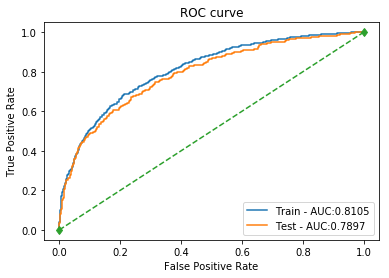

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()
lr.fit(X_train, y_train)

# 预测
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
# 预测概率
y_train_proba = lr.predict_proba(X_train)[:, 1]
y_test_proba = lr.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

<a id='2.2'></a>
## SVM模型

[准确率]
训练集：0.9940
测试集：0.7519
[精准率]
训练集：1.0000
测试集：0.7000
[召回率]
训练集：0.9760
测试集：0.0196
[f1 score]
训练集：0.9879
测试集：0.0380
[auc]
训练集：1.0000
测试集：0.6997
[roc曲线]


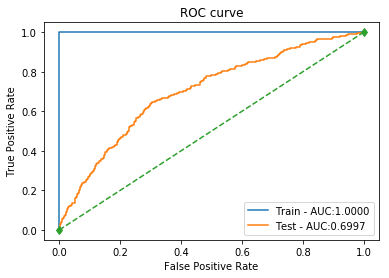

In [23]:
from sklearn.svm import SVC

svc = SVC(C=1.0, kernel='rbf', gamma=0.1, probability=True)
svc.fit(X_train, y_train)

# 预测
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)
# 预测概率
y_train_proba = svc.predict_proba(X_train)[:, 1]
y_test_proba = svc.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

[准确率]
训练集：0.7920
测试集：0.7926
[精准率]
训练集：0.7424
测试集：0.7385
[召回率]
训练集：0.2623
测试集：0.2682
[f1 score]
训练集：0.3876
测试集：0.3934
[auc]
训练集：0.8088
测试集：0.7926
[roc曲线]


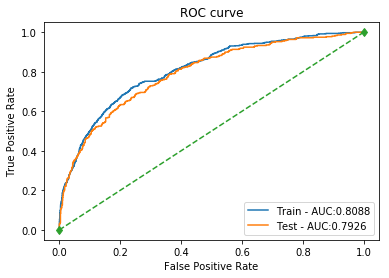

In [24]:
# LinearSVC模型
lin_svc = SVC(kernel='linear', probability=True)
lin_svc.fit(X_train,y_train)

# 预测
y_train_pred = lin_svc.predict(X_train)
y_test_pred = lin_svc.predict(X_test)
# 预测概率
y_train_proba = lin_svc.predict_proba(X_train)[:, 1]
y_test_proba = lin_svc.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

# print y_train[0:100]
# print y_test_pred[0:100]
# print y_test_pred[100:200]

# SVM预测结果都是同一个值，可能原因有：1. 可能是由于样本数据没有归一化导致的。由于维度太大，如果不采用归一化处理的话，各个点的距离值将非常大，
# 故模型对于待预测点的预测结果值都判为同一个值。2. 也有可能是参数的问题。

<a id='2.3'></a>
## DT模型

[准确率]
训练集：0.7027
测试集：0.6685
[精准率]
训练集：0.4444
测试集：0.4080
[召回率]
训练集：0.7377
测试集：0.7123
[f1 score]
训练集：0.5547
测试集：0.5188
[auc]
训练集：0.7832
测试集：0.7207
[roc曲线]


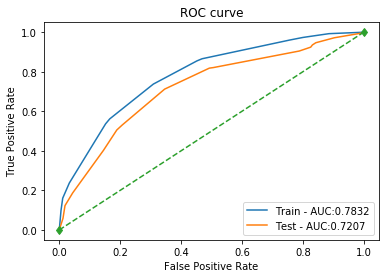

In [25]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

dt.fit(X_train, y_train)

# 预测
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
# 预测概率
y_train_proba = dt.predict_proba(X_train)[:, 1]
y_test_proba = dt.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

# print y_test_pred[0:100]

<a id='2.4'></a>
## XGBoost模型

[准确率]
训练集：0.8479
测试集：0.7898
[精准率]
训练集：0.8553
测试集：0.6343
[召回率]
训练集：0.4743
测试集：0.3827
[f1 score]
训练集：0.6102
测试集：0.4774
[auc]
训练集：0.9089
测试集：0.7925
[roc曲线]


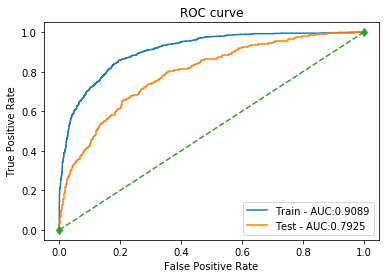

In [60]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# 预测
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
# 预测概率
y_train_proba = xgb.predict_proba(X_train)[:, 1]
y_test_proba = xgb.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

In [ ]:
[准确率]
训练集：0.8479
测试集：0.7898
[精准率]
训练集：0.8553
测试集：0.6343
[召回率]
训练集：0.4743
测试集：0.3827
[f1 score]
训练集：0.6102
测试集：0.4774
[auc]
训练集：0.9089
测试集：0.7924
[roc曲线]

<a id='2.5'></a>
## LightGBM模型

In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier()
lgb.fit(X_train, y_train)

# 预测
y_train_pred = lgb.predict(X_train)
y_test_pred = lgb.predict(X_test)
# 预测概率
y_train_proba = lgb.predict_proba(X_train)[:, 1]
y_test_proba = lgb.predict_proba(X_test)[:, 1]
# 模型评估
model_metrics(X_train, y_train, X_test, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba)

# 模型评估

评估结果

| 模型 | 准确率 | 精准率 | 召回率 | F1 score | AUC | ROC |
| :------ | :------ | :------ | :------ | :------ | :------ | :------ |
| lr | 0.8025; 0.8038 | 0.7051; 0.6990 | 0.3665; 0.3827 | 0.4823; 0.4946 | 0.8105; 0.7897 | ![lr](images/lr.png) |
| svm_linear | 0.7920; 0.7926 | 0.7424; 0.7385 | 0.2623; 0.2682 | 0.3876; 0.3934 | 0.8088; 0.7926 | ![svm_linear](images/linear_svm.png) |
| svm_rbf | 0.9940; 0.7519 | 1.0000; 0.7000 | 0.9760; 0.0196 | 0.9879; 0.0380 | 1.0000; 0.6997 | ![svm_rbf](images/svm.png) |
| dt | 0.7027; 0.6685 | 0.4444; 0.4080 | 0.7377; 0.7123 | 0.5547; 0.5188 | 0.7832; 0.7207 | ![dt](images/dt.png) |
| xgb | 0.8479; 0.7898 | 0.8553; 0.6343 | 0.4743; 0.3827 | 0.6102; 0.4774 | 0.9089; 0.7924 | ![xgb](images/xgb.png) |
| lgb | 0.8479; 0.7898 | 0.8553; 0.6343 | 0.4743; 0.3827 | 0.6102; 0.4774 | 0.9089; 0.7924 | ![xgb](images/xgb.png) |